In [1]:
import pandas as pd
import sys
import numpy as np
import tqdm
import scipy.stats as stats
import matplotlib.pyplot as plt

FIG_DIR = '/home/groups/dpwall/briannac/alt_haplotypes/results/autism_and_sex_association/'

# Unfinished files.

In [2]:
import glob
#finished = [int(i.split('_')[-1][:4]) for i in glob.glob('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/pvals_asd/pvals_asd_*.tsv')]
#set(range(160)).difference(finished)
# Looks like everthing finished.

In [3]:
bam_mappings = pd.read_table('/home/groups/dpwall/briannac/general_data/bam_mappings.csv', index_col=1)
bam_mappings = bam_mappings[bam_mappings.status=='Passed_QC_analysis_ready']
bam_mappings = bam_mappings.drop('09C86428')

# Sex Association

In [5]:
# Get pairings.
samples = bam_mappings.index
affected_pairs = []
unaffected_pairs = []
for f in set(bam_mappings.family):
    fam = bam_mappings[(bam_mappings.family==f) & (bam_mappings.relationship=='sibling')]
    #random
    #sex_numeric = fam.sex_numeric.copy()
    #np.random.shuffle(sex_numeric)
    #fam.sex_numeric = sex_numeric
    affected_females = fam[(fam.sex_numeric=='2.0') & (fam.derived_affected_status=='autism')]
    affected_males = fam[(fam.sex_numeric=='1.0') & (fam.derived_affected_status=='autism')]
    unaffected_females = fam[(fam.sex_numeric=='2.0') & (pd.isna(fam.derived_affected_status))]
    unaffected_males = fam[(fam.sex_numeric=='1.0') & (pd.isna(fam.derived_affected_status))]
    
    affected_pairs = affected_pairs + [(i,j) for i in affected_females.index for j in affected_males.index if ((i in samples) and (j in samples))]
    unaffected_pairs = unaffected_pairs + [(i,j) for i in unaffected_females.index for j in unaffected_males.index if ((i in samples) and (j in samples))]
males = [m for f,m in (affected_pairs + unaffected_pairs)]
females = [f for f,m in (affected_pairs + unaffected_pairs)]    

pvals_sex = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/results/autism_and_sex_association/pvals_se.tsv',
                          sep='\t', index_col=0, header=None, nrows=1000000)
pvals_sex


,1,2
0,,
0,0.111016,1.139665
5,0.995817,1.000000
8,0.157299,0.994778
10,0.103605,0.989529
14,0.317311,1.002618
...,...,...
861677,0.157299,1.005249
861678,0.157299,0.994778
861679,0.687813,0.965368


In [12]:
pvals_sex[1] = [max(p,1e-20) for p in pvals_sex[1]] # Clip pvalues.
pvals_sex[2] = [max(e,-2) if e<0 else min(e,2) for e in np.log2(pvals_sex[2])] # Clip pvalues.


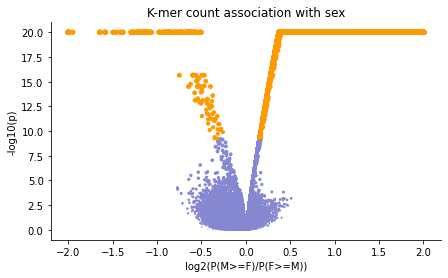

In [5]:
#pvals_sex = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/results/autism_and_sex_association/pvals_sex.tsv', sep='\t', index_col=0, header=None)
#kmer_covs_sex = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/results/autism_and_sex_association/sig_covs_sex.tsv', sep='\t', index_col=0, header=None)
#kmer_covs_sex.columns = bam_mappings.index

cutoff = .05/len(pvals_sex)
no_sig =pvals_sex[pvals_sex[1]>=cutoff].sample(frac=.01)
yes_sig = pvals_sex[pvals_sex[1]<cutoff].sample(frac=.01)

f, ax = plt.subplots(figsize=(7,4))
plt.scatter(no_sig[2], -np.log10(no_sig[1]),
            s=-np.log10(no_sig[1]), color='#8687d1')
plt.scatter(yes_sig[2], -np.log10(yes_sig[1]),
            s=-np.log10(yes_sig[1]), color='#ff9900')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)
plt.xlabel('log2(P(M>=F)/P(F>=M))')
plt.ylabel('-log10(p)')
plt.title('K-mer count association with sex')
plt.savefig(FIG_DIR + 'kmer_count_association_w_sex.svg', transparent=True)
plt.savefig(FIG_DIR + 'kmer_count_association_w_sex.pdf', transparent=True)
plt.show()

# Autism

In [4]:
samples = bam_mappings.index
male_pairs = []
female_pairs = []
for f in set(bam_mappings.family):
    fam = bam_mappings[(bam_mappings.family==f) & (bam_mappings.relationship=='sibling')]
    affected_females = fam[(fam.sex_numeric=='2.0') & (fam.derived_affected_status=='autism')]
    affected_males = fam[(fam.sex_numeric=='1.0') & (fam.derived_affected_status=='autism')]
    unaffected_females = fam[(fam.sex_numeric=='2.0') & (pd.isna(fam.derived_affected_status))]
    unaffected_males = fam[(fam.sex_numeric=='1.0') & (pd.isna(fam.derived_affected_status))]
    male_pairs = male_pairs + [(i,j) for i in affected_males.index for j in unaffected_males.index if ((i in samples) and (j in samples))]
    female_pairs = female_pairs + [(i,j) for i in affected_females.index for j in unaffected_females.index if ((i in samples) and (j in samples))]
affecteds = [a for a,u in (male_pairs + female_pairs)]
unaffecteds = [u for a,u in (male_pairs + female_pairs)]    

In [5]:
pvals_asd = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/results/autism_and_sex_association/pvals_asd.tsv', 
                          sep='\t', index_col=0, header=None)

/home/users/briannac/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


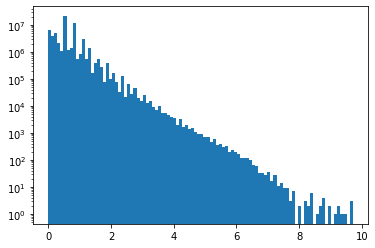

In [6]:
plt.hist(-np.log10(pvals_asd[1]), bins=100)
plt.yscale('log')

61664 8


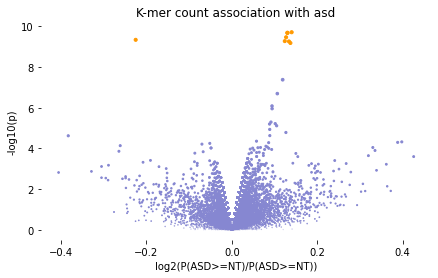

In [7]:
#pvals_asd = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/results/autism_and_sex_association/pvals_asd.tsv', sep='\t', index_col=0, header=None)
#sampled_df=pd.concat([pvals_asd[pvals_asd[1]>=1e-8].sample(frac=.1),pvals_asd[pvals_asd[1]<1e-8]])
#kmer_covs_asd = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/results/autism_and_sex_association/sig_covs_asd.tsv', sep='\t', index_col=0, header=None)
#kmer_covs_asd.columns = bam_mappings.index
cutoff = .05/len(pvals_asd)
no_sig =pvals_asd[pvals_asd[1]>=cutoff].sample(frac=.001)
yes_sig = pvals_asd[pvals_asd[1]<cutoff]

print(len(no_sig), len(yes_sig))
f, ax = plt.subplots(figsize=(7,4))

plt.scatter(np.log2(no_sig[2]), -np.log10(no_sig[1]),
            s=-np.log10(no_sig[1]), color='#8687d1')
plt.scatter(np.log2(yes_sig[2]), -np.log10(yes_sig[1]),
            s=-np.log10(yes_sig[1]), color='#ff9900')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.xlabel('log2(P(ASD>=NT)/P(ASD>=NT))')
plt.ylabel('-log10(p)')
plt.title('K-mer count association with asd')
plt.savefig(FIG_DIR + 'kmer_count_association_w_asd.svg', transparent=True)
plt.savefig(FIG_DIR + 'kmer_count_association_w_asd.pdf', transparent=True)
plt.show()

In [8]:
yes_sig

,1,2
0,,
8254887,5.563854e-10,1.097192
19817481,1.969863e-10,1.101952
25867526,2.101994e-10,1.094421
28610779,4.637679e-10,0.855372
60763356,3.476784e-10,1.092077
84763372,2.109938e-10,1.094421
89802626,5.372326e-10,1.089744
96666970,6.641373e-10,1.099783


In [9]:
','.join([str(int(s)) for s in np.ceil(yes_sig.index/100000)])

'83,199,259,287,608,848,899,967'

In [10]:
sum(pvals_asd[1]<(.05/10000000))

24

In [23]:
# EH DONT DO THIS
#kmer_covs_asd = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/results/autism_and_sex_association/sig_covs_asd.tsv', 
#                              sep='\t', index_col=0, header=None)
#kmer_covs_asd.columns = bam_mappings.index


In [69]:
# Info from BAM mappings.
bam_mappings['counter_idx'] = [i for i in range(len(bam_mappings))]
samples = affecteds+unaffecteds
cols_in_df = bam_mappings.loc[samples].counter_idx.values
kmer_counts = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/counts/unmapped_filt.tsv',
                            header=None, usecols=1+cols_in_df, skiprows=lambda x: x not in yes_sig.index, nrows=max(yes_sig.index))
kmer_counts.columns = samples

ParserError: Error tokenizing data. C error: no error message set

{'bodies': [<matplotlib.collections.PolyCollection at 0x7fad5007d6a0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7fad5007d5f8>,
 'cmins': <matplotlib.collections.LineCollection at 0x7fad5007de80>,
 'cbars': <matplotlib.collections.LineCollection at 0x7fad500a51d0>}

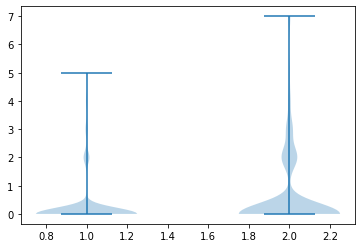

In [30]:
#kmer_counts = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/results/autism_and_sex_association/sig_covs_asd.tsv', 
#                              sep='\t', index_col=0, header=None)
#kmer_counts.columns = bam_mappings.index

for i in range(len(kmer_counts)):
    plt.violinplot([kmer_counts[affecteds].iloc[0].values, kmer_counts[unaffecteds].iloc[0].values])#, alpha=.3, bins=bins) 
    plt.show()
